# Tutorial for Homework 3: Backtesting - Team 7
-----

In this tutorial, we aim to develop a working trading stratergy for day trading stocks and then backtesting that stratergy.  A starting cash on hand for investments is $100,000, and investments are weighted based on predictability with constraints on the number of short/long positions and maximum amount per position. The backtest period include enough data prior to 1/1/2021 to begin trading on the first trading day of 2021. Stocks from the Energy sector were used. Performance measures for the backtest include factors such as the number of long trades, percentage of winning long trades, average return of long trades, number of short trades etc. 

### Learning outcomes
1. Developing a stock investment strategy based on predictability and accuracy.
2. Filtering predictions based on a threshold return level and confidence intervals.
3. Weighing investments based on predictability and employing constraints on investments such as the number of short/long positions and maximum amount per position.
4. Learning how to conduct a backtest period that includes enough data prior to the start of trading and performance measures for evaluating the backtest results.
5. Understanding how to trade both long and short positions on a daily basis as part of an investment strategy.

### Outline of this tutorial

Our tutorial split the task into four subtasks. They are

- **Data preprocessing**: Filter the stocks to only include those in the energy sector in the desired period of time. And exclude any symbols that are removed from S&P in our backtesting period (to avoid running errors).
- **Generating signals/indicators**: Use Holt-Winters method (a time series model) of double exponential smoothing to make predictions about future stock prices. The signals include both the predicted close price on the next day and the sigma (confidence interval) of the prediction.
- **Rule-based trading strategy**: Filter the predictions based on a threshold of return level and determine the amount based on the confidence intervals. Trade both long and short positions on a daily basis, using the filtered predictions to make investment decisions.
- **Running the strategy, backtesting, and performance evaluation**: Run the developed strategy with a given initial fund. Apply constraints and adjustment to the strategy. Then evaluate performance measures for the backtest on factors such as the percentage of winning trades, Sharpe Ratio, cumulative portfolio return, and maximum drawdown.

Loading libraries for this tutorial: 
To execute this stratergy, we would need the following libraries. Two new libraries are used in this tutorial. The `zoo` library provides function regarding matrix processing. We specifically use the `rollapply` function from the library as a more efficient alternative of for-loop when compute the signal given windows. The `forecast` library provides a rich collection of time series models including the `ets` model we use.

In [1]:
library(dplyr, warn.conflicts = FALSE)
library(tidyverse, warn.conflicts = FALSE)
library(zoo, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)
library(forecast, warn.conflicts = FALSE)
options(dplyr.summarise.inform = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ stringr 1.5.0
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### Pre-processing with the given data

We start by loading the data and sampling a subset within the given time range and from the energe sector. We plan to use a window size of 20. Therefore, we set the starting date to 2020-12-03, which is 20 trading days earlier than 2021-01-01.

In [2]:
load("universe.rdata")
from<-as.Date("2020-12-03")
to<-as.Date("2023-12-23")
universe<-subset(universe,universe$Sector=="Energy"&
                 universe$date>=from&universe$date<=to)

Our strategy will be simply based on the open and close price. Therefore we only keep the desired columns in the dataframe. We also remove duplicated rows in the dataframe (just in case).

In [3]:
universe<-universe[, c('symbol', 'date', 'open', 'high', 'low', 'close')]
universe<-unique(universe)
universe<-universe[order(universe$symbol,universe$date),]

To avoid the case that "a stock which we have opening positions is removed from S&P 500 and its future data is lacking" happens, we also remove stocks that are removed from or added to the S&P 500 within the time period. This is to simplify the exception handling of our strategy. In practice, 

- For removed stocks, since there would be notification several days before a stock is removed, we can just avoid the trading of that stock in advance (by removing it from the dataframe).

- For newly added stocks, we can still use their history data even they are not in S&P 500.

In [4]:
maxdate <- max((universe %>% group_by(symbol) %>% summarize(days=n()))[,2])
maxdate

[1] 555

We know that if a symbol belongs to S&P 500 during the entire time period and remains tradable, the total number of days will be 785. Next, we filter out any symbols that have less than 555 trading days.

In [5]:
keep_symbol <- universe %>% group_by(symbol) %>% 
    summarise(days=n()) %>% mutate(keep = (days==maxdate))
universe <- universe[merge(universe, keep_symbol, by='symbol')$keep,]

Below is a summary of the processed dataset. We now have 11655 entries in the table, with the starting date 2020-12-03, and end date 2023-02-16.

In [6]:
summary(universe)

    symbol               date                 open             high       
 Length:11655       Min.   :2020-12-03   Min.   :  6.14   Min.   :  6.31  
 Class :character   1st Qu.:2021-06-23   1st Qu.: 26.39   1st Qu.: 26.85  
 Mode  :character   Median :2022-01-10   Median : 56.90   Median : 57.90  
                    Mean   :2022-01-10   Mean   : 66.44   Mean   : 67.57  
                    3rd Qu.:2022-08-01   3rd Qu.: 91.53   3rd Qu.: 92.97  
                    Max.   :2023-02-16   Max.   :286.49   Max.   :288.46  
      low              close       
 Min.   :  6.005   Min.   :  6.19  
 1st Qu.: 25.933   1st Qu.: 26.39  
 Median : 55.960   Median : 56.94  
 Mean   : 65.321   Mean   : 66.48  
 3rd Qu.: 89.885   3rd Qu.: 91.47  
 Max.   :282.310   Max.   :285.28  

We then set the constraints including initial equility, max long trades per day, max short trades per day and the return threshold

In [7]:
symbols<-unique(universe$symbol)
dates <- unique(universe$date)
numsymbols<-length(symbols)

window<-20
initialequity<-100000
maxlongtrades<-10
maxshorttrades<-5
returnthreshold<-0.02

Our strategy will be executed on the following symbols from the energy sector of S&P 500.

In [8]:
symbols

[1] "APA"  "BKR"  "COP"  "CVX"  "DVN"  "EOG"  "FANG" "HAL"  "HES"  "KMI" 
[11] "MPC"  "MRO"  "NOV"  "OKE"  "OXY"  "PSX"  "PXD"  "SLB"  "VLO"  "WMB" 
[21] "XOM"

In [9]:
length(symbols)

[1] 21

### Generating signals using time series models.

For-loops in R are less efficient than `apply`, we try to use the function `rollapply` as an alternative to for-loops when computing the forecasting results. The `rollapply` requires two key inputs. The first is `width` denoting the size of window for each time-series model fitting (and forecasting). The second is `FUN`, which is a customized function that takes a subset of the dataframe (e.g., rows from `t` to `t+window`) as inputs and returns the forecast value (e.g., for row `t+window+1`).

In [10]:
ets_forecast <- function (window) {
    stock.ts <- ts(as.numeric(window[, 6]))
    fit <- ets(stock.ts, model='ZZZ')
    predicted <- forecast(fit, h=1)$mean
    sigma <- sqrt(fit$sigma2)
    return(c(predicted, sigma))
}

We use the function `lag()` to shift the predicted value forward by 1 day because the prediction is for the next day.

In [11]:
result <- universe %>% 
    group_by(symbol) %>% 
    rollapply(., width=window, FUN=ets_forecast, by.column=FALSE, align='right', fill=NA) %>% 
    lag(.)

predicted <- as.data.frame(result, colnames(result))
colnames(predicted)<-c("Predicted", "Sigma")

In [12]:
predicted <- cbind(universe, predicted)

In [13]:
tail(predicted)

symbol,date,open,high,low,close,Predicted,Sigma
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XOM,2023-02-09,114.62,116.24,114.180,114.35,113.5905,0.01673834
XOM,2023-02-10,116.51,119.63,116.160,119.17,113.9663,0.01650032
XOM,2023-02-13,117.72,118.18,115.900,117.80,117.1383,0.01953941
XOM,2023-02-14,117.01,117.81,116.017,116.42,117.6095,0.01948617
XOM,2023-02-15,115.72,116.09,114.140,116.07,116.8613,0.01928072
XOM,2023-02-16,115.31,116.78,114.800,115.73,116.3892,2.17474623


### Rules based on the prediction and confidence interval

We apply the following rules to determine the trade position and the amount.

Long or short is determined by predicted mean:
- When mean predicted close price increases by 5% or more from the open, we long the stock,
- When mean predicted close price decreases by 5% or more from the open, we short the stock.

Amount is determined by the confidence interval (Sigma in the table):
- If `sigma`/`predicted price` is less than 1%, invest 10% of capital (equivalent to up 3%+ with 95% confidence),
- Else, if `sigma`/`predicted price` is less than 2%, invest 5% of capital (equivalent to up 1%+ with 95% confidence, or up 3% with 87% confidence),
- Else, if `sigma`/`predicted price` is less than 5%, invest 2% of capital (equivalent to up with 87% confidence).


In [14]:
applyRules <- function(total_cash, open, sigma, predicted){
    if ((predicted - open)/open >= returnthreshold) {longshort <- 1}
    else {
        if ((open - predicted)/open >= returnthreshold) {longshort <- -1}
        else return(0)}
    
    abs_shares <- 0
    if (sigma/predicted < 0.01) abs_shares <- floor(0.1*total_cash/open) # integer shares
    else {
        if (sigma/predicted < 0.02) abs_shares <- floor(0.05*total_cash/open)
        else if (sigma/predicted < 0.05) abs_shares <- floor(0.02*total_cash/open)
    }
    return(longshort*abs_shares)
}

### Apply contraints and adjust the trading strategies.

Once we have the initial strategy, we apply contraints on ***max position number*** and ***max fund amount*** based on the expected return and total cost. Then we ***update the strategy*** with contraints applied before we compute the actual return.

We keep track the daily trading operations by two additional columns in the dataframe, `trade_shares`, `expected_return`, and `cash_balance`. The two columns are calculated based on the rule and are sufficient to calculate the return of each trade.

- `trade_shares` is an integer value tracking the number of shares traded at the opening of the day. If the value is positive, then the stock has a long position. Otherwise, we have a short position. It is directly given by the trading rules.
- `expected_return` is obtained by multuplying `trade_shares`*(`Predicted`-`open`). ***It will be used to determine which trades will be kept when contrains like max positions are exceed.*** Namely, we only keep the ***top-K profitable trades*** given a max number of positions K. 
- `actual_return` is obtained by calculating `trade_shares`*(`close`-`open`) subject to stop-loss `trade_shares` * `open`*10%. It will be used to calculate the `cash_balance` at the end of the day and the performance evaluation.

In addition, we include the overall `cash_balance` for individual days to track the cash after trading at the end of the day. It is computed by `cash_balance at t-1` + $\sum_{all-symbol}$ (`close`-`open`)*`trade_shares`. ***It will be used to determine the amout of money we invest to each stock on the next day.*** Moreover, it will be used to compute the overall performance of our strategy.

**Calculating the columns**: because the amount of a position is based on the `cash_balance` of the previous day, and the `cash_balance` of each day is affected by the `expected_return` of all stocks due to the constraints, we need to calculate the values in new columns following the order of date. 

**To apply the constraints of maximum long/short positions**, we first compute the expected return of all candidate trades. Then for both long and short, we only keep the **top-k trade based on the expected return** (k is the max position constraint). The threshold is obtained by the following code. We also provide a test case to validate the implementation.

In [15]:
get_topk <- function(expected_return, trade_shares, k_long, k_short){
    values <- sign(trade_shares)*expected_return
    th_long <- max(sort(values)[length(values)-k_long+1], 0)
    th_short <- min(sort(values)[k_short], 0)
    return(c(th_long, -th_short))
}

# Test the function
test_return <- c(100, 200, 300, 150, 220, 120)
test_shares <- c(-10, 2, 8, -15, 20, 12)
th <- get_topk(test_return, test_shares, 2, 1)
th

[1] 220 150

In this testing example, if long a stock, the expected profit must be greater than 220; if short a stock, the profit must be greater than 150. So that there are at most 2 long positions and 1 short position, individually. We will use the thresholds to adjust the dataframe to fulfill the constraints.

**To apply the contraints of maximum amount of capital/equity**, we ***evenly shrunk*** all opening positions if the cost of opening positions exceed the maximum amount of capital/equity. Specifically, we update `trade_shares` by `new trade_share` = `floor` ( `max_capital` / `total_cost` * `trade_share` ). We implement the shrunking together with the filter by thresholds for the previous contraints in the following function.

In [16]:
filter_and_shrunk <- function(stocks, max_cash, max_long, max_short){
    # filter by thresholds
    th <- get_topk(stocks$expected_return, stocks$trade_shares, max_long, max_short)
    stocks %>% mutate(
        trade_shares=ifelse(
            sign(trade_shares)*expected_return>=(th[1])|
            sign(trade_shares)*expected_return<=(-th[2]),
            trade_shares, 0
        ))

    # shrunk by max_cash/total_cost if exceeded
    total_cost <- sum(stocks$trade_shares*stocks$open)
    if (total_cost > max_cash) {
        shrunk <- max_cash/total_cost
        stocks$trade_shares <- floor(stocks$trade_shares*shrunk)
    }
    stocks <- stocks %>% mutate(expected_return=trade_shares*(Predicted-open))
    return(stocks)
}

We also include the ***stop-loss strategy***; namely when an opening position has lost more than 10% within the day, we stop loss before the market close. This is especially crucial for short position (we don't want to be short-squeezed!). In back-testing, for a long position, if the `low` is 10%+ down compared to `open`, we say the stop loss order is trigered. And the return of that day becomes (`open` * `trade_shares` * 10%) instead of (`close`-`open`) * `trade_shares` even if `close` is higher than `open`.

Considering the stop-loss strategy, we implement the function to calculate the `actual_return` column.

In [17]:
get_return <- function(stocks, stop_loss_perc=0.1){
    stocks <- stocks %>% mutate(
        actual_return=ifelse(
            trade_shares>0 & (low-open)/open>stop_loss_perc|  # for long
            trade_shares<0 & (high-open)/open>stop_loss_perc, # for short 
            -open*trade_shares*stop_loss_perc, # if stop loss
            (close-open)*trade_shares # if not stopped
    ))
    return(stocks)
}

### Backtesting and performance evaluation

We first add columns with initial values to the dataframe.

In [18]:
predicted['trade_shares'] <- 0
predicted['expected_return'] <- 0
predicted['actual_return'] <- 0

We now use all functions defined above to compute, adjust the tradings traversing each trading days, and compute the actual return of each trade, and finally compute the total equity we have (or our cash balance at the end of) each day.

In [19]:
cash <- initialequity
record <- c(cash)
for (date in dates[(window+1):length(dates)]){
    stocks <- predicted[predicted['date']==date,]
    stocks <- stocks %>% mutate(
        trade_shares=applyRules(cash, open, Sigma, Predicted),
        expected_return=trade_shares*(Predicted-open))
    
    stocks <- filter_and_shrunk(stocks, cash, maxlongtrades, maxshorttrades)
    stocks <- get_return(stocks)
    predicted[predicted['date']==date,] <- stocks
    cash <- cash + sum(stocks$actual_return) # cash amout at the end of trading
    record <- c(record, cash)
}

In [20]:
back_test <- predicted[predicted$date>=dates[window+1],]

Below is how finally the table looks like.

In [21]:
head(back_test)

symbol,date,open,high,low,close,Predicted,Sigma,trade_shares,expected_return,actual_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
APA,2021-01-04,14.650,14.950,14.38,14.77,14.27552,0.62852688,-136,50.92923,-16.32
APA,2021-01-05,14.860,16.728,14.86,16.18,14.62482,0.03730348,0,0.00000,0.00
APA,2021-01-06,16.404,17.075,15.69,16.84,16.17985,0.65007269,0,0.00000,0.00
APA,2021-01-07,17.000,17.500,16.73,17.11,16.83993,0.66749863,0,0.00000,0.00
APA,2021-01-08,17.360,17.450,16.30,16.58,17.10997,0.66771744,0,0.00000,0.00
APA,2021-01-11,15.950,16.750,15.79,16.66,16.58005,0.58289641,126,79.38668,89.46


Now we construct a new dataframe to compare the return of our strategy with one baseline strategy.

In [22]:
trade_dates <- dates[(window+1):length(dates)]
our_return <- record[-1]/record[1]
buy_hold_xom <- back_test[back_test$symbol=='XOM',]$close
buy_hold_xom <- buy_hold_xom/buy_hold_xom[1]
comparison <- data.frame(trade_dates, our_return, buy_hold_xom)

In [23]:
head(comparison)

,trade_dates,our_return,buy_hold_xom
,<date>,<dbl>,<dbl>
1,2021-01-04,0.9996743,1.000000
2,2021-01-05,1.0107018,1.048193
3,2021-01-06,1.0040789,1.074940
4,2021-01-07,1.0039760,1.083373
5,2021-01-08,1.0058310,1.095422
6,2021-01-11,1.0346472,1.128675


Using the below code we plot the performance comparison between our strategy and the buy&hold strategy with XOM only. Note that since the performance is not a primary goal of this homework, we did not tune or optimize our models and strategies. And our strategy is relatively preservative. Therefore, the performance of our strategy is not that competative to the buy&hold.

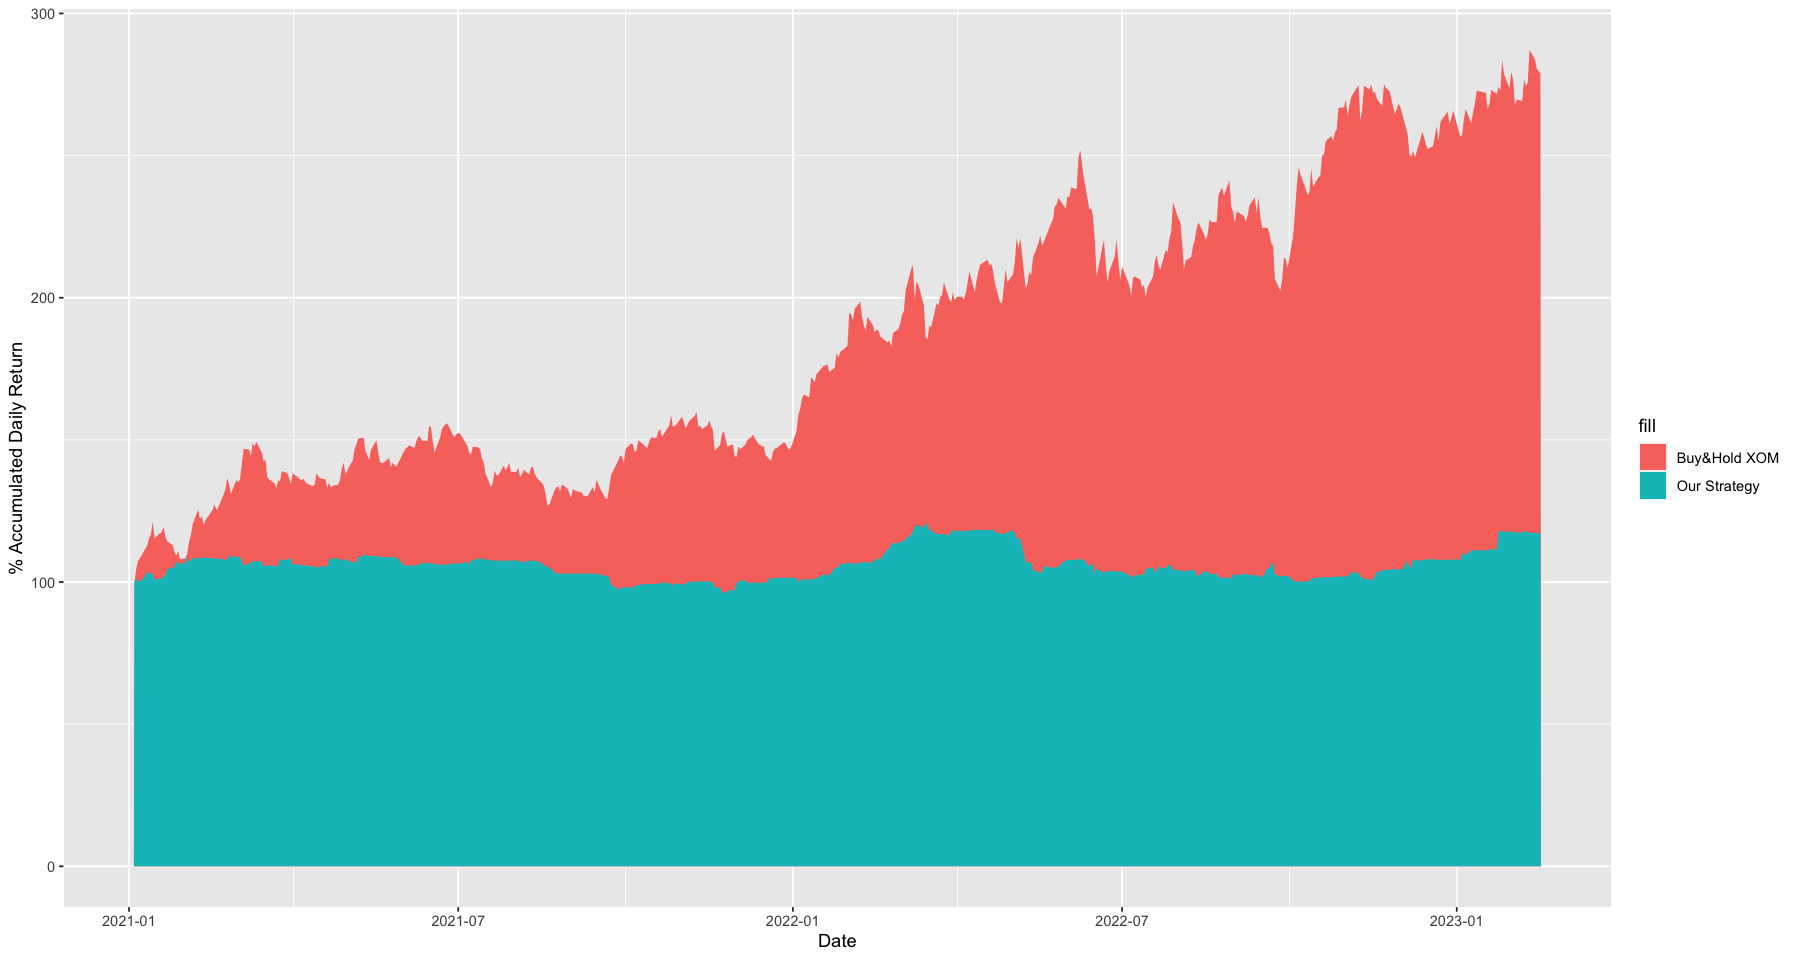

In [24]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(comparison, aes(x=trade_dates)) +
    geom_area(aes(y=buy_hold_xom*100, fill = "Buy&Hold XOM")) +
    geom_area(aes(y=our_return*100, fill = "Our Strategy")) +
    labs(y='% Accumulated Daily Return', x='Date')

One thing worthnoting from the plot is that, the return of ***our strategy has a low correlation*** to the price change itself (from both the figure and the quantitative results below). The profit periods of our strategy are usually during the drawdown of the price itself. And the loss periods usually happens when the price goes up. It indicates that our strategy can be used to deversify the portfolio (something like CTA strategies).

In [25]:
cor(comparison$our_return, comparison$buy_hold_xom)

[1] 0.2462149

Now, we **Generate performance summary** from the dataframe with actual returns.
- **Max drawdown**: we implement function that takes the vector of daily equity (cash balance at the end of each day) as input, and compute the maximum drawdown percentage and period by traversing all dates once and keeping track the max equity and max draw down so far. The complexity of this algorithm is O(N).

In [26]:
max_drawdown <- function(equity, dates){
    max_equity <- 0
    max_equity_date <- dates[1]
    max_drawdown <- 0
    for (i in 1:length(equity)){
        if (equity[i]>=max_equity) {
            max_equity <- equity[i]
            max_equity_date <- dates[i]
        }
        else {
            drawdown <- (max_equity - equity[i])/max_equity
            if (drawdown >= max_drawdown) {
                max_drawdown <- drawdown
                max_drawdown_period <- dates[i] - max_equity_date
            }
        }
    }
    return(c(percent(max_drawdown, 0.1), max_drawdown_period))
}

The max percentage of drawdown, and the period of that drawdown (in days) are:

In [27]:
max_drawdown(record, dates[(window+1):length(dates)])

[1] "16.9%" "209"

- **Number of (winning) trades** can be easily summarized from the result table as follows.

The number of long trades, percentage of winning long trades, and the average return of long trades are:

In [28]:
num_long <- sum(back_test$trade_shares>0)
win_long <- sum(back_test$trade_shares>0&back_test$actual_return>0)
perc_winlong <- percent(win_long/num_long, 0.1)
avgret_long <- mean(back_test[back_test$trade_shares>0,]$actual_return)
c(num_long, perc_winlong, avgret_long)

[1] "1223"            "54.2%"           "12.255547833197"

The number of short trades, percentage of winning short trades, and the average return of short trades are:

In [29]:
num_short <- sum(back_test$trade_shares<0)
win_short <- sum(back_test$trade_shares<0&back_test$actual_return>0)
perc_winshort <- percent(win_short/num_short, 0.1)
avgret_short <- mean(back_test[back_test$trade_shares<0,]$actual_return)
c(num_short, perc_winshort, avgret_short)

[1] "1078"             "49.1%"            "1.99805844155844"

The percentage of overall winning trades is:

In [30]:
perc_winall <- percent((win_long+win_short)/(num_long+num_short), 0.1)
perc_winall

[1] "51.8%"

- **Sharpe ratio** is defined as $r = \frac{R-R_0}{\sigma}$, where $R$ is the return of our strategy, $R_0$ is the risk-free return, which we set to $0.12\%$ using the 2-year yield on 2021/01/03 which is the beginning of our back-test period. $\sigma$ is the standard deviation of the return

The accumulated return and the Sharpe ratio of above strategy are:

In [31]:
sigma <- sd(record/record[1])
final_return <- (record[length(record)]-record[1])/record[1]
r <- (final_return-0.0012)/sigma
c(percent(final_return, 0.1), r)

[1] "17.1%"            "3.17288082210213"